# Part IV: Validation and Testing

Authors: Jordi Bolibar & Facundo Sapienza

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 4.1 Cross-validation and testing

The goal of this notebook is to explore different validation and testing methodologies that you can use and the respective considerations you have to consider at the moment of assessing the performance of a given model, either for model selection or test report. 

When training and testing a model, we usually split the dataset among three different sets: training, validation and testing set. Sometimes, this split of the data is done automatically by the method we use, and sometimes instead of a simple split of the dataset into K folds is done iteratively (eg, in k-fold cross-validation). Independently of how we implement this, we need to understand the limitations and considerations we need to have at the moment we do the split. This considerations can include:

- Sampling procedure
- Spatial and temporal correlations between data points
- Size of data available
- Nature of the datasets: where are they coming from? How independent are they?

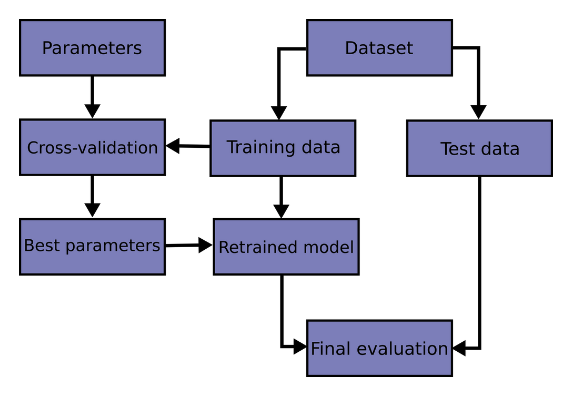

*Figure 1: Cross-validation workflow.*

### [ **Exercice 3** ]
<img src="Figures/eye_logo.png" width="75"/>

How would you design a validation-testing workflow for the problem of predicting the mass balance? How would you divide the different folds?

For an excellent introduction to cross-validation, as well as the different high-level function to implement it in `sklearn` models, checkout [this tutorial](https://scikit-learn.org/stable/modules/cross_validation.html). 

This notebook is up to you to define it. Choose a cross-validation approach, and use it in one of the machine learning models you chose from the previous notebook. Try to tune the hyperparameters as much as you can in cross-validation. In the end, once you are sure you cannot improve performance anymore, load the **test** dataset that we saved in the previous notebook, and assess the final model performance with your selected hyperparameters.

### Happy coding! 

## 4.2 Hyperparameter selection in cross-validation for a chosen model

To start, we will explore using GridSearch to choose our hyperparameters. If given enough time, we can then go back and customize how we pick our validation sets.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

In [54]:
# bring in the data
df_test = pd.read_csv('Data/df_test.csv',index_col=['rgi_id', 'period'])
df_train_all = pd.read_csv('Data/df_train_all.csv',index_col=['rgi_id', 'period'])

In [55]:
# drop unneeded features
features_to_drop = ['dmdtda', 'err_dmdtda', 'target_id']

df_train_X = df_train_all.drop(features_to_drop, axis=1)
df_train_y = df_train_all[['dmdtda']]

X_train, y_train = df_train_X.values, df_train_y.values

# repeat on test data
df_test_X = df_test.drop(features_to_drop, axis=1)
df_test_y = df_test[['dmdtda']]

X_test, y_test = df_test_X.values, df_test_y.values

In [5]:
# set a hyperparameter dictionary
params = {'objective':['reg:absoluteerror'],
          'tree_method':['approx'],
          'enable_categorical':['True'],
          'max_depth': [2,3,4],
          'n_estimators': [50,100,200],}

# params = {'objective':['reg:absoluteerror'],
#           'tree_method':['approx'],
#           'enable_categorical':['True'],
#           'max_depth': [2,3,4],
#           'learning_rate': [0.01, 0.1,0.3,],
#           'n_estimators': [50,100,200],
#           'colsample_bytree': [0.2,0.3,0.4],
#           'min_split_loss': [0,10,20],
#           'max_depth': [0,4,6],
#           'reg_lambda': [0,5,10],
#           'alpha': [0,25,50],
#           'max_delta_step': [0,50,100]}

In [6]:
# call the model
xgb_model = xgb.XGBRegressor()

In [7]:
# fit the grid search
clf = GridSearchCV(xgb_model, params, cv=5)
clf.fit(X_train, y_train)
# after cv, consider adding verbose=1 or some other #

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'enable_categorical': ['True'], 'max_depth': [2, 3, 4],
                         'n_estimators': [50, 100, 200],
                         'objective': ['reg:absoluteerror'],
                         'tree_method': ['approx']})

In [8]:
# verbose=1
print(clf.best_score_)
print(clf.best_params_)

0.20433903815371143
{'enable_categorical': 'True', 'max_depth': 2, 'n_estimators': 50, 'objective': 'reg:absoluteerror', 'tree_method': 'approx'}


## 4.3 Testing the final model

In [9]:
# bring in the plot_prediction function

def plot_prediction(y1, y2, n_toplot=10**10):
    
    from scipy.stats import gaussian_kde
    from sklearn.metrics import r2_score, mean_squared_error
    
    idxs = np.arange(len(y1))
    np.random.shuffle(idxs)
    
    y_expected = y1.reshape(-1)[idxs[:n_toplot]]
    y_predicted = y2.reshape(-1)[idxs[:n_toplot]]

    xy = np.vstack([y_expected, y_predicted])
    z = gaussian_kde(xy)(xy)
    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    y_plt, ann_plt, z = y_expected[idx], y_predicted[idx], z[idx]
    
    plt.figure(figsize=(8,8))
    plt.title("Model Evaluation", fontsize=17)
    plt.ylabel('Modeled SMB (m.w.e)', fontsize=16)
    plt.xlabel('Reference SMB (m.w.e)', fontsize=16)
    sc = plt.scatter(y_plt, ann_plt, c=z, s=20)
    plt.clim(0,0.4)
    plt.tick_params(labelsize=14)
    plt.colorbar(sc) 
    lineStart = -2.5
    lineEnd = 1.5
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-')
    plt.axvline(0.0, ls='-.', c='k')
    plt.axhline(0.0, ls='-.', c='k')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.gca().set_box_aspect(1)
    
    textstr = '\n'.join((
    r'$RMSE=%.2f$' % (mean_squared_error(y_expected, y_predicted), ),
    r'$R^2=%.2f$' % (r2_score(y_expected, y_predicted), )))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    
    plt.show()

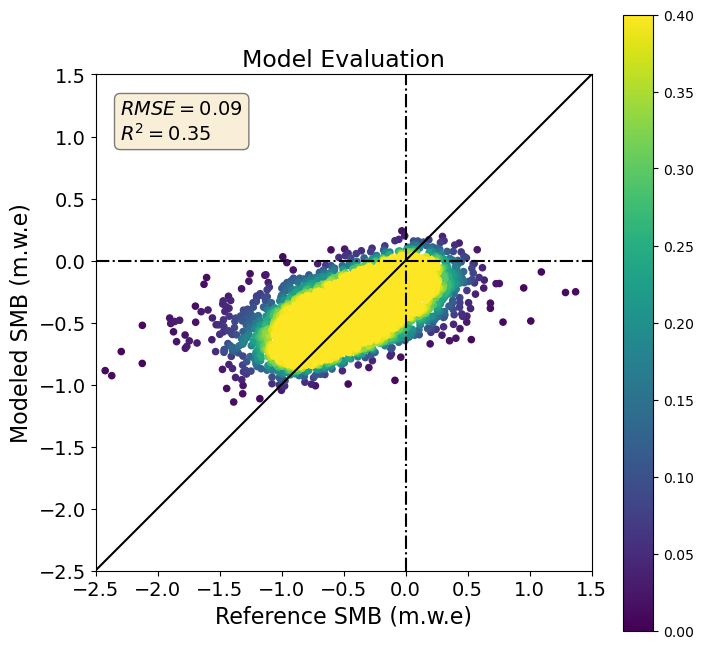

In [10]:
# plot training vs. model
plot_prediction(y_train, clf.predict(X_train), n_toplot=5000)

In [52]:
# predictions
pred_train = clf.predict(X_train)
pred_test = clf.predict(X_test)

In [31]:
np.save('Data/pred_train.npy', pred_train) # save
np.save('Data/pred_test.npy', pred_test)
# pred_train = np.load('Data/pred_train.npy') # load

In [12]:
from sklearn.metrics import mean_absolute_error

In [19]:
# error scores

# train
data3 = pd.DataFrame()
data3['Predicted Target'] = pred_train
print('Train RMSE: ',mean_absolute_error(y_train,data3['Predicted Target']))

# test
data2 = pd.DataFrame()
data2['Predicted Target'] = pred_test
print('Test  RMSE: ',mean_absolute_error(y_test,data2['Predicted Target']))

Train RMSE:  0.219330180456382
Test  RMSE:  0.2449348530502511


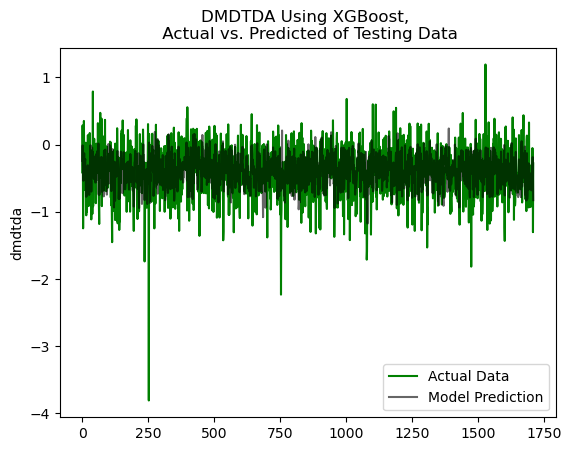

In [56]:
plt.plot(y_test, color='green',label='Actual Data')
plt.plot(pred_test,color='black',
         alpha=0.6,label='Model Prediction')
# plt.xlabel('Date')
plt.ylabel('dmdtda')
plt.legend(loc='best')

plt.title('DMDTDA Using XGBoost, \n Actual vs. Predicted of Testing Data');

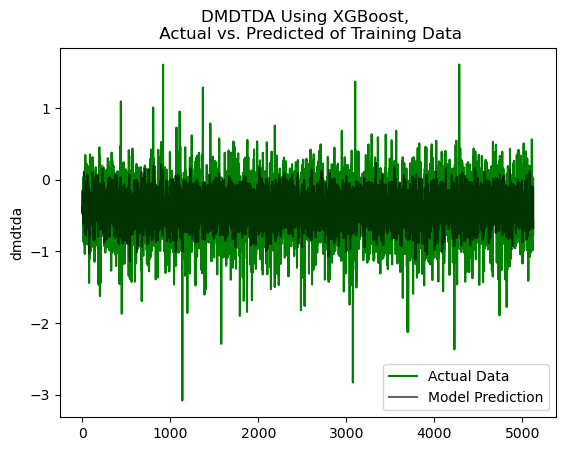

In [33]:
plt.plot(y_train, color='green',label='Actual Data')
plt.plot(pred_train,color='black',
         alpha=0.6,label='Model Prediction')
# plt.xlabel('Date')
plt.ylabel('dmdtda')
plt.legend(loc='best')

plt.title('DMDTDA Using XGBoost, \n Actual vs. Predicted of Training Data');

In [63]:
ind = np.argsort(y_test.reshape(-1))
y_test_sorted = y_test[ind].reshape(-1)
pred_test_sorted = pred_test[ind].reshape(-1)

In [64]:
y_test_sorted

array([-3.807 , -2.2323, -1.816 , ...,  0.6788,  0.7893,  1.1914])

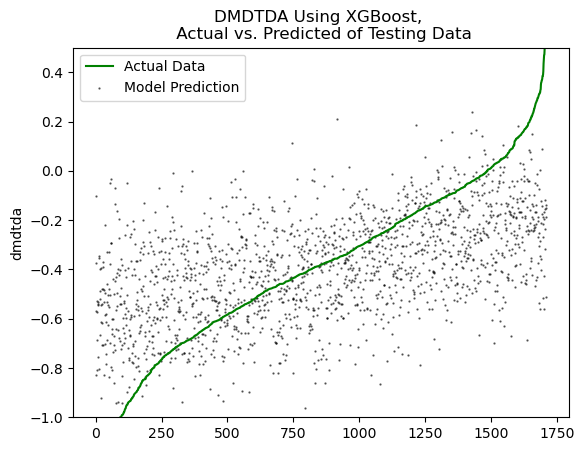

In [70]:
plt.plot(y_test_sorted, color='green',label='Actual Data')
plt.scatter(np.arange(0, pred_test_sorted.shape[0]),pred_test_sorted,color='black',
         alpha=0.6,label='Model Prediction', s=0.4)
# plt.xlabel('Date')
plt.ylabel('dmdtda')
plt.legend(loc='best')
plt.ylim(-1, .5)

plt.title('DMDTDA Using XGBoost, \n Actual vs. Predicted of Testing Data');

In [71]:
ind = np.argsort(y_train.reshape(-1))
y_train_sorted = y_train[ind].reshape(-1)
pred_train_sorted = pred_train[ind].reshape(-1)

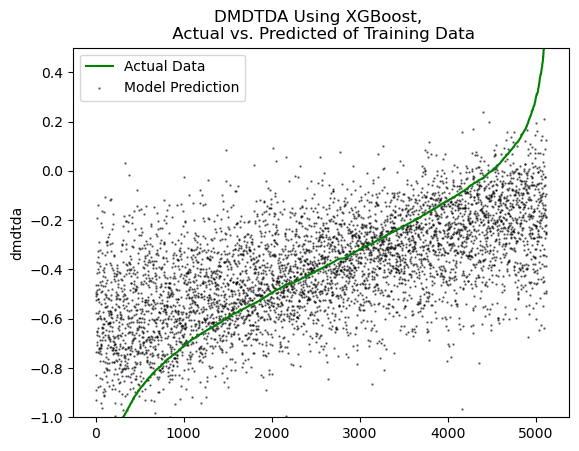

In [72]:
plt.plot(y_train_sorted, color='green',label='Actual Data')
plt.scatter(np.arange(0, pred_train_sorted.shape[0]),pred_train_sorted,color='black',
         alpha=0.6,label='Model Prediction', s=0.4)
# plt.xlabel('Date')
plt.ylabel('dmdtda')
plt.legend(loc='best')
plt.ylim(-1, .5)

plt.title('DMDTDA Using XGBoost, \n Actual vs. Predicted of Training Data');

Can we weight the extreme values in a way that helps us better catch the magnitudes?